In [1]:
import os
import random
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

In [3]:
transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])


In [5]:
from google.colab import drive
from torchvision import datasets, transforms

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
dataset_path = '/content/drive/MyDrive/MRI'

##Training and Testing

In [8]:
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

In [9]:
class_names=dataset.classes
print(class_names)
print(len(class_names))

['Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1', 'Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1C+', 'Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T2', 'Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1', 'Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1C+', 'Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T2', 'NORMAL T1', 'NORMAL T2', 'Neurocitoma (Central - Intraventricular, Extraventricular) T1', 'Neurocitoma (Central - Intraventricular, Extraventricular) T1C+', 'Neurocitoma (Central - Intraventricular, Extraventricular) T2', 'Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T1', 'Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T1C+', 'Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T2', 'Schwannoma (Acustico, Vestibular - Trigeminal) T1', 'Schwannoma (Acustico

In [10]:
torch.manual_seed(10)
test_size = len(dataset)//5
train_size = len(dataset) - test_size

train_ds, test_ds = random_split(dataset, [train_size, test_size])
len(train_ds), len(test_ds)

(3559, 889)

In [11]:
train_loader=DataLoader(train_ds,batch_size=16,shuffle=True)
test_loader=DataLoader(test_ds,batch_size=16)

##Check Images and Labels

In [12]:
for images, labels in train_loader:
    break
#print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im=make_grid(images,nrow=8)

Label: [ 5  4  6 14  0  1 10  9  0 11  3  4  3  5  7 16]
Class: Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T2 Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1C+ NORMAL T1 Schwannoma (Acustico, Vestibular - Trigeminal) T1 Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1 Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1C+ Neurocitoma (Central - Intraventricular, Extraventricular) T2 Neurocitoma (Central - Intraventricular, Extraventricular) T1C+ Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1 Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T1 Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1 Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1C+ Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1 Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T2 NORMAL T2 Schwanno

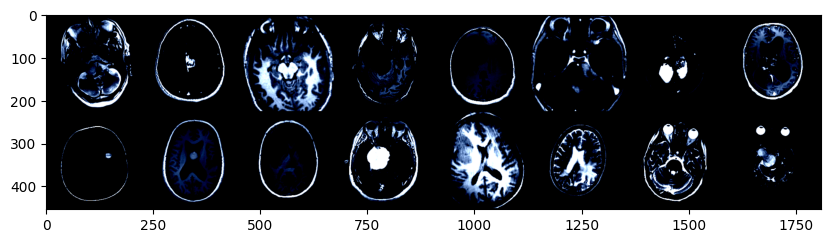

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [14]:
inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                    std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

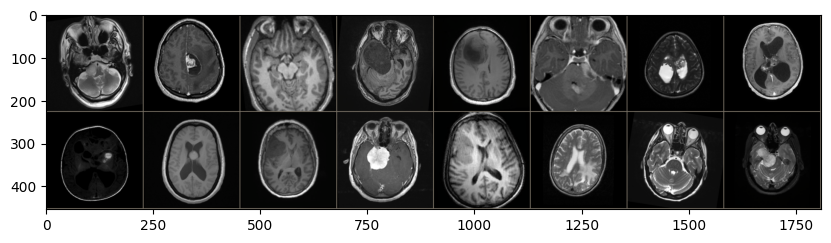

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

##CNN Model

In [18]:
class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,6,3,1)
        self.conv2=nn.Conv2d(6,16,3,1)
        self.fc1=nn.Linear(16*54*54,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,20)
        self.fc4=nn.Linear(20,len(class_names))

    def forward(self,X):
        #print(X.shape)#torch.Size([10,3,224,224])
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,16*54*54)
        X=F.relu(self.fc1(X))
        X=F.relu(self.fc2(X))
        X=F.relu(self.fc3(X))
        X=self.fc4(X)
        X=F.log_softmax(X,dim=1)
        #print(X.shape)#torch.Size([10,80])
        return X

In [19]:
mycnn=MyCNN()
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(mycnn.parameters(),lr=0.001)

In [20]:
mycnn

MyCNN(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=17, bias=True)
)

In [21]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')
count_parameters(mycnn)

     162
       6
     864
      16
 5598720
     120
   10080
      84
    1680
      20
     340
      17
________
 5612109


In [28]:
epochs=10

In [29]:
import time
start_time=time.time()
train_losses=[]
test_losses=[]
train_correct=[]
test_correct=[]


for i in range(epochs):
    trn_corr=0
    tst_corr=0
    for b, (X_train,y_train) in enumerate(train_loader):
        b+=1
        y_pred=mycnn(X_train)
        loss=criterion(y_pred,y_train)
        #true predictions
        predicted=torch.max(y_pred.data,1)[1]
        batch_corr=(predicted==y_train).sum()
        trn_corr+=batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%200==0:
            print(f"epoch: {i} loss: {loss.item} batch: {b} accuracy: {trn_corr.item()*100/(10*b):7.3f}%")
    loss=loss.detach().numpy()
    train_losses.append(loss)
    train_correct.append(trn_corr)


    with torch.no_grad():
        for b, (X_test,y_test) in enumerate(test_loader):
            y_val=mycnn(X_test)
            loss=criterion(y_val,y_test)

            predicted=torch.max(y_val.data,1)[1]
            btach_corr=(predicted==y_test).sum()
            tst_corr+=btach_corr

        loss=loss.detach().numpy()
        test_losses.append(loss)
        test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch: 0 loss: <built-in method item of Tensor object at 0x7d623fdc0310> batch: 200 accuracy: 108.850%
epoch: 1 loss: <built-in method item of Tensor object at 0x7d623eab0b80> batch: 200 accuracy: 124.050%
epoch: 2 loss: <built-in method item of Tensor object at 0x7d623ef8e930> batch: 200 accuracy: 130.650%
epoch: 3 loss: <built-in method item of Tensor object at 0x7d623fdc1210> batch: 200 accuracy: 138.300%
epoch: 4 loss: <built-in method item of Tensor object at 0x7d623eab0c70> batch: 200 accuracy: 142.550%
epoch: 5 loss: <built-in method item of Tensor object at 0x7d623ea465c0> batch: 200 accuracy: 144.000%
epoch: 6 loss: <built-in method item of Tensor object at 0x7d623ef11710> batch: 200 accuracy: 147.300%
epoch: 7 loss: <built-in method item of Tensor object at 0x7d623fe028e0> batch: 200 accuracy: 148.350%
epoch: 8 loss: <built-in method item of Tensor object at 0x7d623ef8dcb0> batch: 200 accuracy: 149.700%
epoch: 9 loss: <built-in method item of Tensor object at 0x7d623ea87100> 

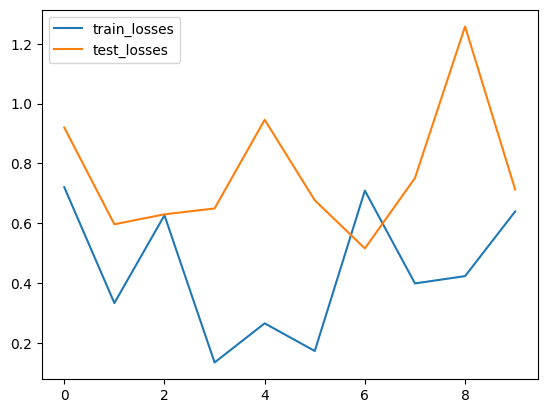

In [30]:
plt.plot(train_losses,label="train_losses")
plt.plot(test_losses,label="test_losses")
plt.legend()

##AlexNetModel

In [31]:
alex= models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:04<00:00, 53.7MB/s]


In [32]:
alex

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [33]:
for param in alex.parameters():
    param.requires_grad=False

In [34]:
torch.manual_seed(42)

alex.classifier=nn.Sequential(nn.Linear(9216,1024),
                                     nn.ReLU(),
                                     nn.Dropout(p=0.5),
                                     nn.Linear(1024,80),
                                     nn.LogSoftmax(dim=1))
alex

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, 

In [35]:
count_parameters(alex)


 9437184
    1024
   81920
      80
________
 9520208


In [36]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(alex.classifier.parameters(),lr=0.001)

In [37]:
epochs=10

In [38]:
import time
start_time=time.time()
train_losses=[]
test_losses=[]
trn_correct=[]
tst_correct=[]

for i in range(epochs):
    trn_corr=0
    tst_corr=0
    for b, (X_train,y_train) in enumerate(train_loader):
        b+=1

        y_pred=alex(X_train)
        loss=criterion(y_pred,y_train)
        #Update parameters
        predicted=torch.max(y_pred.data,1)[1]
        batch_corr=(predicted==y_train).sum()
        trn_corr+= batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%200==0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    loss=loss.detach().numpy()
    train_losses.append(loss)
    train_correct.append(trn_corr)

    with torch.no_grad():
        for b, (X_test,y_test) in enumerate(test_loader):
            b+=1

            y_val=alex(X_test)
            predicted=torch.max(y_val.data,1)[1]
            btach_corr=(predicted==y_test).sum()
            tst_corr+=btach_corr

    loss=criterion(y_val,y_test)
    loss=loss.detach().numpy()
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch:  0  batch:  200 [  2000/8000]  loss: 1.17274129  accuracy:  77.550%
epoch:  1  batch:  200 [  2000/8000]  loss: 1.12296200  accuracy: 105.300%
epoch:  2  batch:  200 [  2000/8000]  loss: 1.31544924  accuracy: 114.200%
epoch:  3  batch:  200 [  2000/8000]  loss: 0.56927425  accuracy: 117.150%
epoch:  4  batch:  200 [  2000/8000]  loss: 0.50715214  accuracy: 122.750%
epoch:  5  batch:  200 [  2000/8000]  loss: 0.58910114  accuracy: 126.100%
epoch:  6  batch:  200 [  2000/8000]  loss: 0.71104348  accuracy: 125.200%
epoch:  7  batch:  200 [  2000/8000]  loss: 1.61936390  accuracy: 130.500%
epoch:  8  batch:  200 [  2000/8000]  loss: 0.74912131  accuracy: 126.000%
epoch:  9  batch:  200 [  2000/8000]  loss: 0.27926058  accuracy: 132.400%

Duration: 2434 seconds


##Prediction

In [39]:
device = torch.device("cpu")   #"cuda:0"

In [40]:
mycnn.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = mycnn(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
print(y_pred[0:5])

[0, 2, 4, 4, 10]


In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

                                                                                       precision    recall  f1-score   support

  Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1     0.8776    0.8600    0.8687       100
Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1C+     0.8462    0.8021    0.8235        96
  Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T2     0.6667    0.8684    0.7543        76
                   Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1     0.6829    0.7778    0.7273        72
                 Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1C+     0.7518    0.9060    0.8217       117
                   Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T2     0.8333    0.6061    0.7018        66
                                                                            NORMAL T1     0.9516    0.8676    

In [42]:
alex.eval()
ay_true=[]
ay_pred=[]
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = alex(test_images).argmax(dim=1)
        for i in range(len(pred)):
            ay_true.append(test_labels[i].item())
            ay_pred.append(pred[i].item())
print(ay_pred[0:5])

[3, 2, 3, 4, 10]


In [43]:
from sklearn.metrics import classification_report
print(classification_report(ay_true,ay_pred,target_names=class_names,digits=4))

                                                                                       precision    recall  f1-score   support

  Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1     0.9010    0.9100    0.9055       100
Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1C+     0.9529    0.8438    0.8950        96
  Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T2     0.6506    0.7105    0.6792        76
                   Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1     0.7791    0.9306    0.8481        72
                 Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1C+     0.9043    0.8889    0.8966       117
                   Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T2     0.6377    0.6667    0.6519        66
                                                                            NORMAL T1     0.9828    0.8382    